Predicting Hypoxic Regions Using CNN with Oversampling and Stratified K-Fold Cross-Validation


This pipeline uses a CNN-based deep learning model for predicting hypoxic regions (low oxygen levels) in marine waters. The model leverages spatial patterns in oceanographic data.

1. Dataset Preparation

    The dataset is preprocessed by normalizing features using StandardScaler to ensure uniformity and scale independence.
    The data is split into an 80% training set and a 20% holdout set for evaluation.
    SMOTE (Synthetic Minority Oversampling Technique) is applied to address the class imbalance between hypoxic and non-hypoxic regions, ensuring fair training.

Dataset Summary:
            Latitude      Longitude         Depth   Oxygen_Value  \
count  133549.000000  133549.000000  133549.00000  133549.000000   
mean       -6.227246     -10.923800    1218.44821     199.062570   
std        44.017819     110.337699    1317.86417      78.527776   
min       -77.500000    -177.500000       5.00000       0.000000   
25%       -42.500000    -112.500000     100.00000     154.227000   
50%       -12.500000     -17.500000     700.00000     203.070000   
75%        22.500000      87.500000    1900.00000     247.129000   
max        87.500000     177.500000    5500.00000     457.073000   

       Salinity_Value  Temperature_Value  
count   133549.000000      133549.000000  
mean        34.648312           6.429536  
std          1.125943           7.671785  
min          4.795000          -2.042000  
25%         34.490000           1.477000  
50%         34.683000           3.024000  
75%         34.897000           9.386000  
max         40.573000     

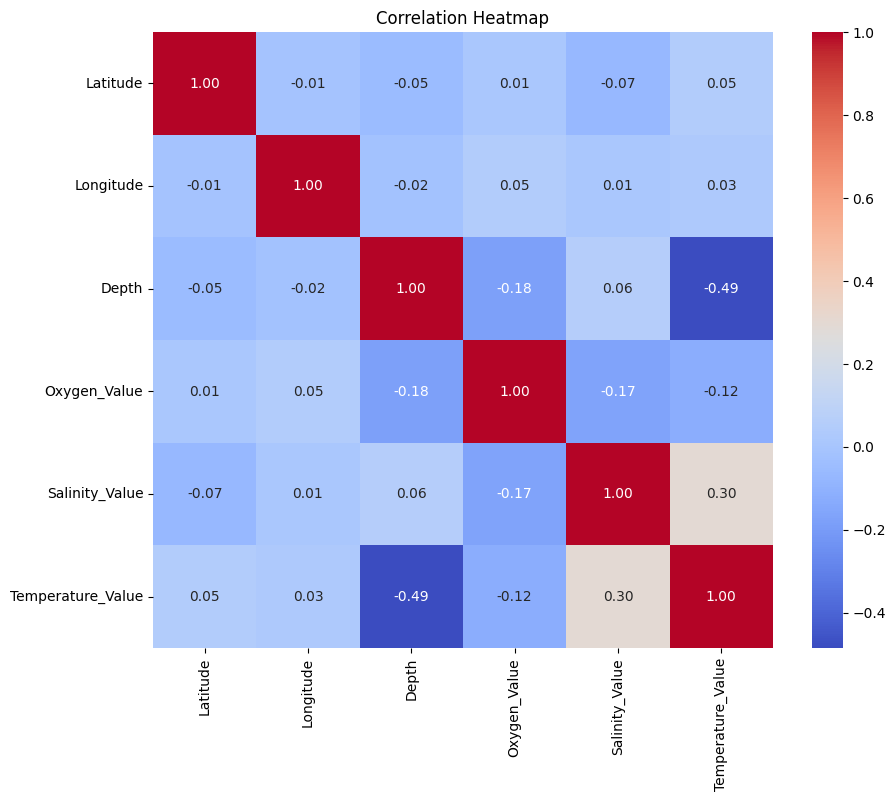

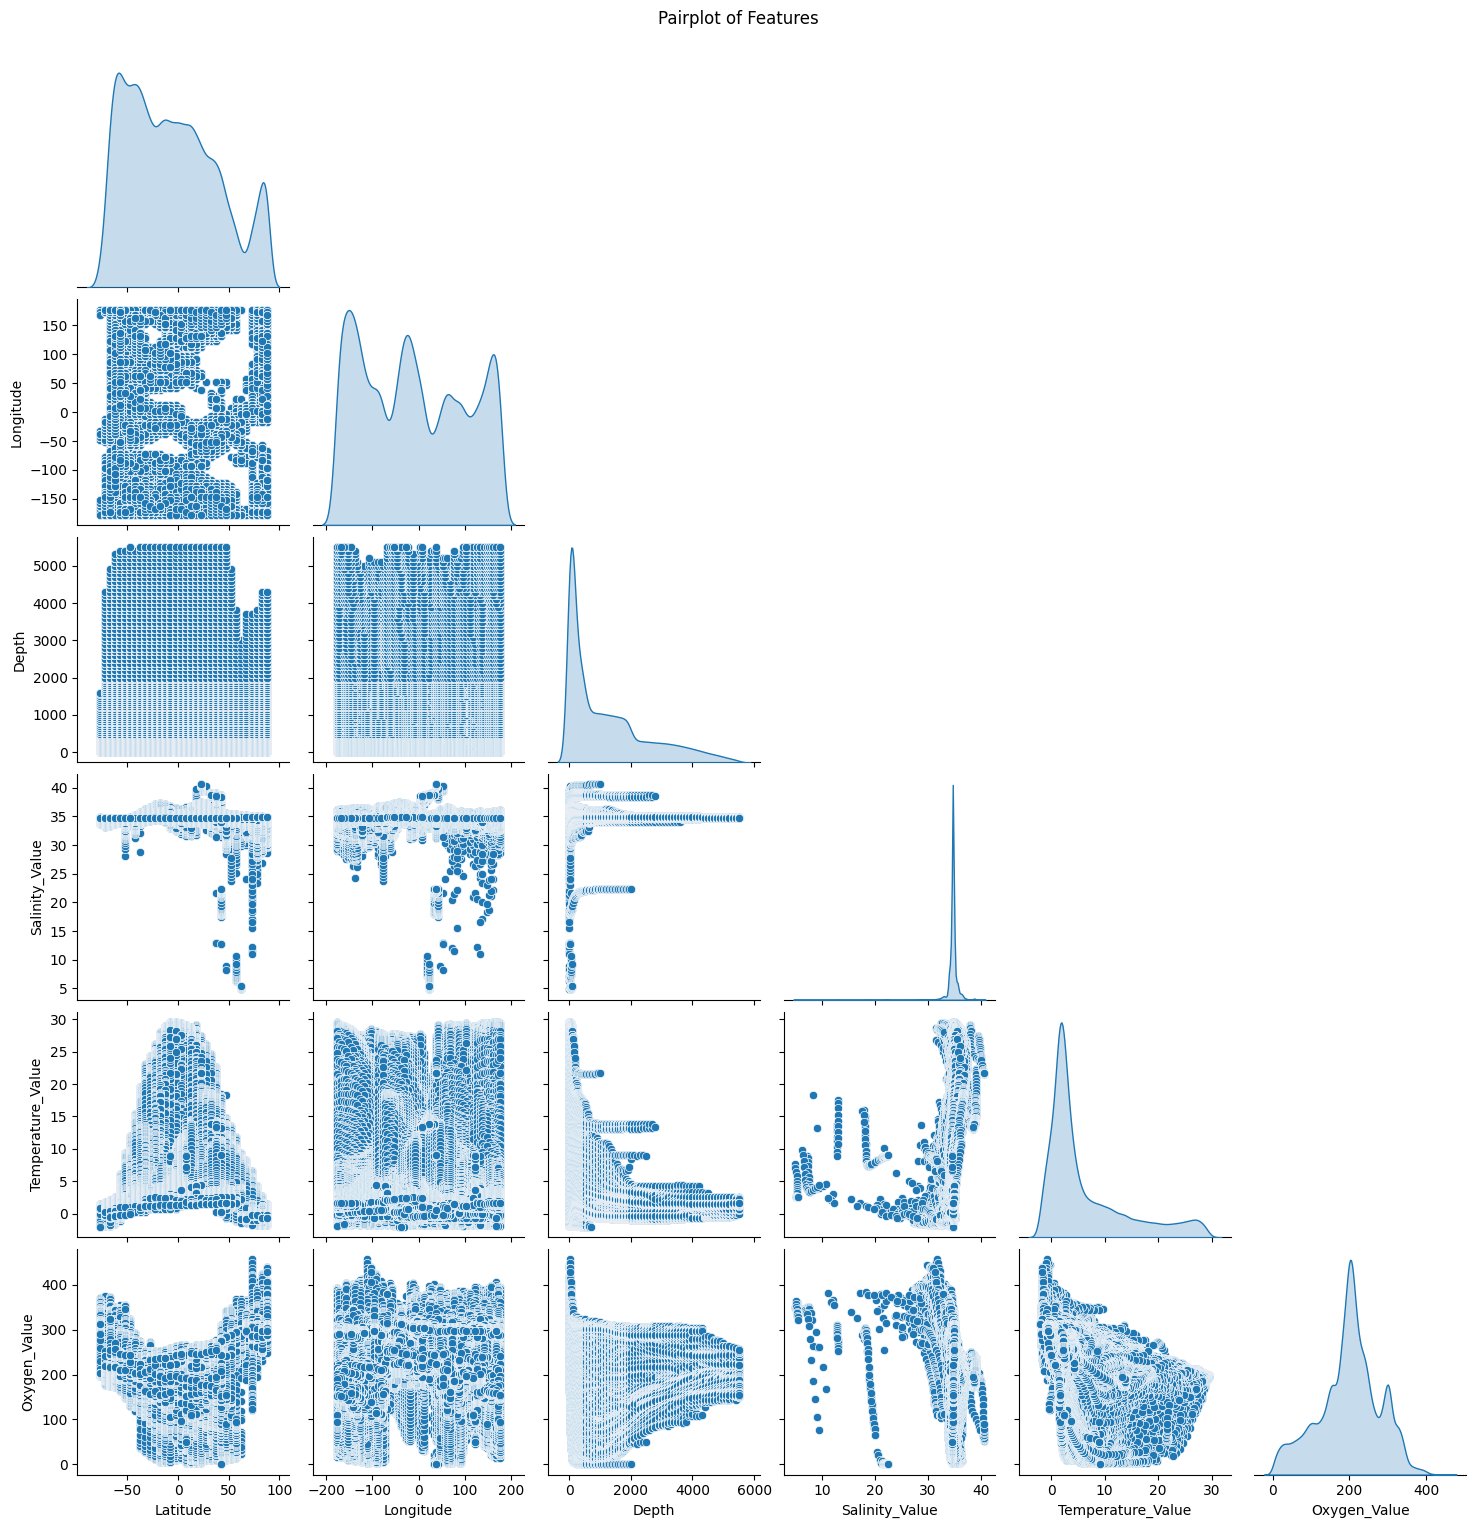

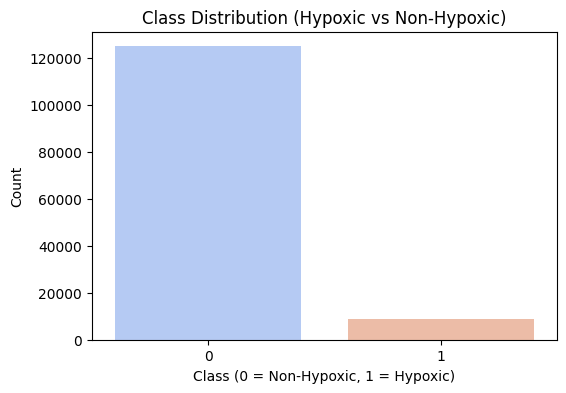

Class distribution in Train: Counter({0: 99833, 1: 7006})
Class distribution in Holdout: Counter({0: 24959, 1: 1751})


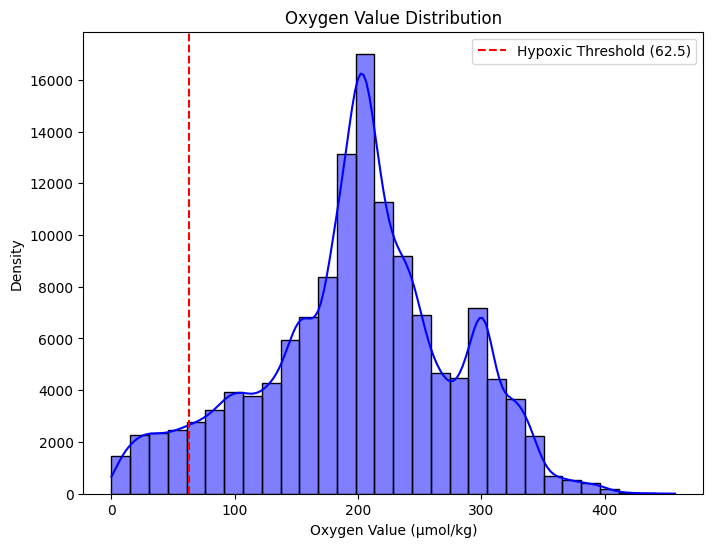

In [21]:
# Import Libraries
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('combined_oceanographic_data.csv')

# EDA: Basic Statistics
print("Dataset Summary:")
print(data.describe())

# EDA: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# EDA: Pairplot of features
sns.pairplot(
    data[['Latitude', 'Longitude', 'Depth', 'Salinity_Value', 'Temperature_Value', 'Oxygen_Value']],
    diag_kind='kde',
    palette='coolwarm',
    corner=True
)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

# Define the hypoxic threshold (62.5 µmol/kg)
hypoxic_threshold = 62.5
data['Hypoxic'] = (data['Oxygen_Value'] <= hypoxic_threshold).astype(int)  # 1 = Hypoxic, 0 = Non-Hypoxic

# EDA: Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data['Hypoxic'], palette='coolwarm')
plt.title("Class Distribution (Hypoxic vs Non-Hypoxic)")
plt.xlabel("Class (0 = Non-Hypoxic, 1 = Hypoxic)")
plt.ylabel("Count")
plt.show()

# Extract features and target
features = data[['Latitude', 'Longitude', 'Depth', 'Salinity_Value', 'Temperature_Value']].values
oxygen_values = data['Oxygen_Value'].values
labels = data['Hypoxic'].values

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into a train/holdout split
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print class distributions
print("Class distribution in Train:", Counter(y_train_full))
print("Class distribution in Holdout:", Counter(y_holdout))

# EDA: Distribution of Oxygen Values
plt.figure(figsize=(8, 6))
sns.histplot(data['Oxygen_Value'], kde=True, bins=30, color='blue')
plt.axvline(x=hypoxic_threshold, color='red', linestyle='--', label=f'Hypoxic Threshold ({hypoxic_threshold})')
plt.title("Oxygen Value Distribution")
plt.xlabel("Oxygen Value (µmol/kg)")
plt.ylabel("Density")
plt.legend()
plt.show()


Correlation Heatmap: Indicates relationships between features, showing that depth is negatively correlated with temperature, and most features have weak inter-correlations.

Pairplot of Features: Highlights feature distributions and relationships; distinct clusters in depth and oxygen value suggest natural stratification in the dataset.

Class Distribution (Hypoxic vs Non-Hypoxic): Shows significant imbalance, with non-hypoxic regions being the majority, requiring oversampling to balance the classes.

Oxygen Value Distribution: Displays a skewed distribution of oxygen values, with most samples above the hypoxic threshold (62.5 µmol/kg), confirming the dataset imbalance.

### 2. Addressing Class Imbalance and Model Training

The training set is oversampled using SMOTE during cross-validation to balance class distributions.

=== Fold 1/5 ===
Class distribution after SMOTE (Fold 1): Counter({0: 79866, 1: 79866})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9523 - loss: 0.1274 - val_accuracy: 0.9666 - val_loss: 0.0777
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9759 - loss: 0.0677 - val_accuracy: 0.9780 - val_loss: 0.0612
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9800 - loss: 0.0577 - val_accuracy: 0.9731 - val_loss: 0.0629
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9826 - loss: 0.0511 - val_accuracy: 0.9739 - val_loss: 0.0681
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9832 - loss: 0.0484 - val_accuracy: 0.9757 - val_loss: 0.0558
Validation Loss: 0.0558, Validation Accuracy: 0.9757
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19967
           1       0.73      0.99      0.84      1401

    accuracy                           0.98     21368
   macro avg       0.87 

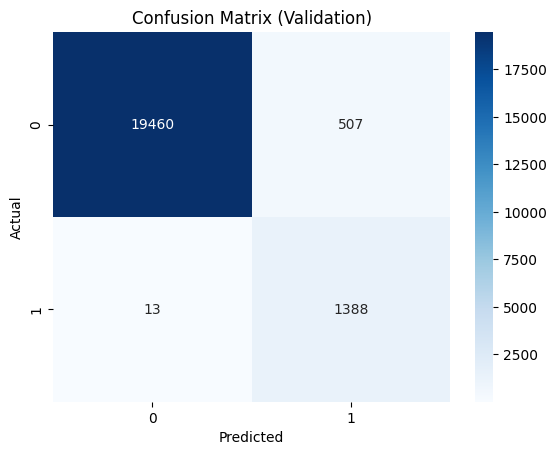

=== Fold 2/5 ===
Class distribution after SMOTE (Fold 2): Counter({0: 79866, 1: 79866})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9535 - loss: 0.1250 - val_accuracy: 0.9750 - val_loss: 0.0552
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9778 - loss: 0.0641 - val_accuracy: 0.9757 - val_loss: 0.0545
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9808 - loss: 0.0555 - val_accuracy: 0.9810 - val_loss: 0.0464
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9838 - loss: 0.0497 - val_accuracy: 0.9798 - val_loss: 0.0485
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9847 - loss: 0.0457 - val_accuracy: 0.9730 - val_loss: 0.0650
Validation Loss: 0.0650, Validation Accuracy: 0.9730
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19967
           1       0.71      0.99      0.83      1401

    accuracy                           0.97     21368
   macro avg       0.86 

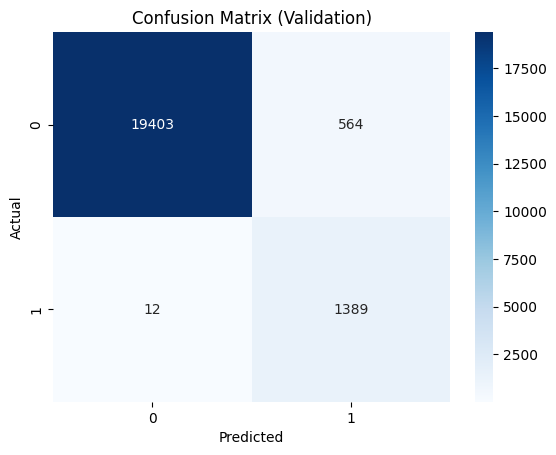

=== Fold 3/5 ===
Class distribution after SMOTE (Fold 3): Counter({1: 79866, 0: 79866})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9543 - loss: 0.1237 - val_accuracy: 0.9584 - val_loss: 0.1001
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9770 - loss: 0.0670 - val_accuracy: 0.9681 - val_loss: 0.0722
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9804 - loss: 0.0565 - val_accuracy: 0.9763 - val_loss: 0.0583
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9824 - loss: 0.0514 - val_accuracy: 0.9762 - val_loss: 0.0593
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9841 - loss: 0.0470 - val_accuracy: 0.9759 - val_loss: 0.0552
Validation Loss: 0.0552, Validation Accuracy: 0.9759
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19967
           1       0.74      0.98      0.84      1401

    accuracy                           0.98     21368
   macro avg       0.87 

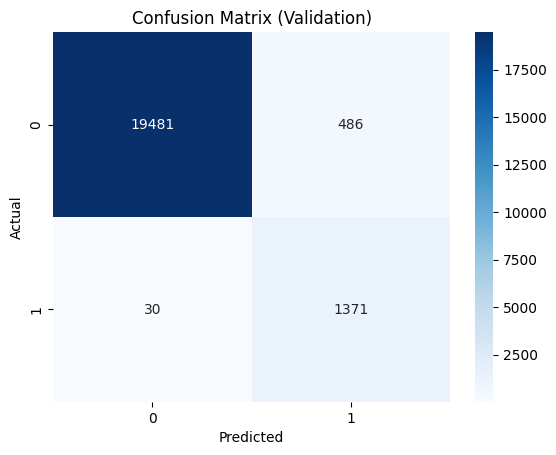

=== Fold 4/5 ===
Class distribution after SMOTE (Fold 4): Counter({0: 79867, 1: 79867})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9519 - loss: 0.1278 - val_accuracy: 0.9709 - val_loss: 0.0715
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9765 - loss: 0.0664 - val_accuracy: 0.9707 - val_loss: 0.0674
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9801 - loss: 0.0588 - val_accuracy: 0.9708 - val_loss: 0.0751
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9828 - loss: 0.0503 - val_accuracy: 0.9783 - val_loss: 0.0533
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9838 - loss: 0.0483 - val_accuracy: 0.9742 - val_loss: 0.0692
Validation Loss: 0.0692, Validation Accuracy: 0.9742
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19966
           1       0.72      1.00      0.84      1402

    accuracy                           0.97     21368
   macro avg       0.86 

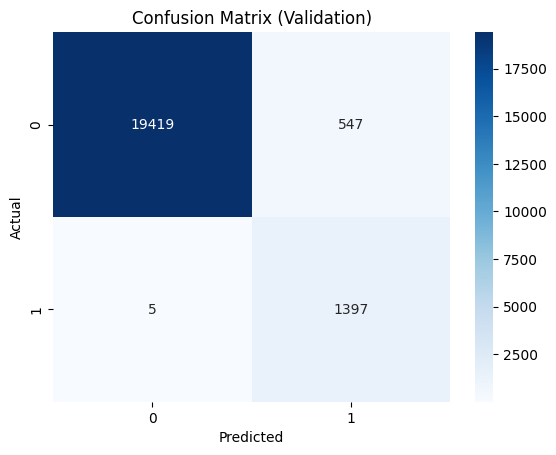

=== Fold 5/5 ===
Class distribution after SMOTE (Fold 5): Counter({0: 79867, 1: 79867})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9530 - loss: 0.1256 - val_accuracy: 0.9579 - val_loss: 0.1121
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9760 - loss: 0.0675 - val_accuracy: 0.9719 - val_loss: 0.0669
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9797 - loss: 0.0576 - val_accuracy: 0.9789 - val_loss: 0.0494
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9824 - loss: 0.0523 - val_accuracy: 0.9779 - val_loss: 0.0528
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9822 - loss: 0.0503 - val_accuracy: 0.9760 - val_loss: 0.0677
Validation Loss: 0.0677, Validation Accuracy: 0.9760
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19966
           1       0.73      0.99      0.84      1401

    accuracy                           0.98     21367
   macro avg       0.87 

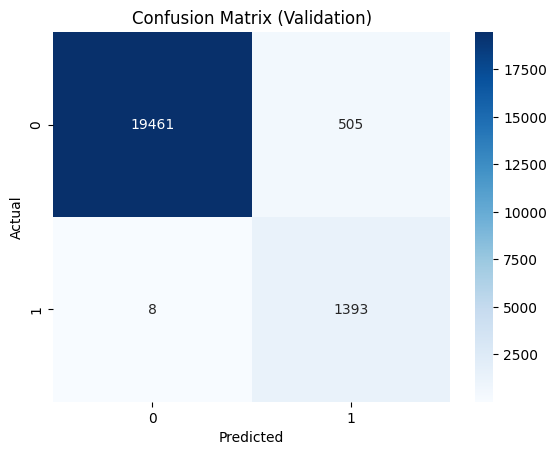


=== Final Metrics Across Folds ===
Mean Accuracy: 0.9749 ± 0.0012
Mean ROC-AUC: 0.9972 ± 0.0003


In [16]:
# Define Stratified K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize metrics storage
roc_auc_scores = []
accuracy_scores = []
fold = 1

for train_index, test_index in skf.split(X_train_full, y_train_full):
    print(f"=== Fold {fold}/{n_splits} ===")
    
    # Split data for the current fold
    X_train, X_valid = X_train_full[train_index], X_train_full[test_index]
    y_train, y_valid = y_train_full[train_index], y_train_full[test_index]
    
    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"Class distribution after SMOTE (Fold {fold}):", Counter(y_train_resampled))
    
    # Reshape data for CNN
    X_train_cnn = X_train_resampled.reshape(-1, 5, 1, 1)
    X_valid_cnn = X_valid.reshape(-1, 5, 1, 1)
    
    # Define CNN model
    model = Sequential([
        Conv2D(32, kernel_size=(2, 1), activation='relu', input_shape=(5, 1, 1)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(2, 1), activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification output
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_cnn, y_train_resampled,
        validation_data=(X_valid_cnn, y_valid),
        epochs=5,
        batch_size=32,
        verbose=1
    )
    
    # Evaluate on validation data
    valid_loss, valid_accuracy = model.evaluate(X_valid_cnn, y_valid, verbose=0)
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")
    accuracy_scores.append(valid_accuracy)
    
    # Predict on validation data
    y_valid_pred = model.predict(X_valid_cnn).flatten()
    y_valid_classes = (y_valid_pred >= 0.5).astype(int)
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_valid, y_valid_pred)
    roc_auc_scores.append(roc_auc)
    
    # Display metrics
    print("\nClassification Report:")
    print(classification_report(y_valid, y_valid_classes))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_valid, y_valid_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    fold += 1

# Final Metrics Across Folds
print("\n=== Final Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Mean ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")


5. Holdout Test Set Evaluation

Confusion Matrix (Holdout Test Set): Demonstrates that the model correctly classified the majority of non-hypoxic (24,352) and hypoxic (1,741) regions, with minimal false negatives (10) and moderate false positives (607).

Final Metrics:

    Mean Accuracy: 97.49% across folds, indicating robust performance.
    Mean ROC-AUC: 99.72%, showing excellent discriminatory power.

Holdout Classification Report:

    High recall (99%) for the hypoxic class indicates the model's reliability in detecting low-oxygen regions.
    Moderate precision (74%) for the hypoxic class suggests occasional false positives, possibly due to class imbalance.

Holdout Test Loss: 0.0610, Holdout Test Accuracy: 0.9769
835/835 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Holdout ROC-AUC: 0.9976

Holdout Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24959
           1       0.74      0.99      0.85      1751

    accuracy                           0.98     26710
   macro avg       0.87      0.98      0.92     26710
weighted avg       0.98      0.98      0.98     26710


Holdout Confusion Matrix:


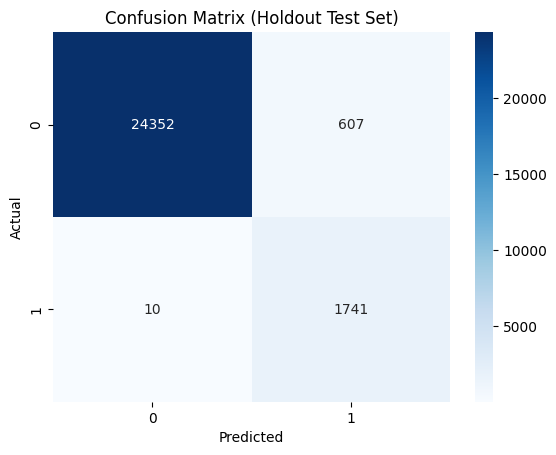

In [17]:
# Reshape holdout set for CNN
X_holdout_cnn = X_holdout.reshape(-1, 5, 1, 1)

# Evaluate the model on holdout test set
holdout_loss, holdout_accuracy = model.evaluate(X_holdout_cnn, y_holdout, verbose=0)
print(f"Holdout Test Loss: {holdout_loss:.4f}, Holdout Test Accuracy: {holdout_accuracy:.4f}")

# Predict and evaluate on holdout set
y_holdout_pred = model.predict(X_holdout_cnn).flatten()
y_holdout_classes = (y_holdout_pred >= 0.5).astype(int)

# Holdout ROC-AUC
holdout_roc_auc = roc_auc_score(y_holdout, y_holdout_pred)
print(f"Holdout ROC-AUC: {holdout_roc_auc:.4f}")

# Holdout Metrics
print("\nHoldout Classification Report:")
print(classification_report(y_holdout, y_holdout_classes))
print("\nHoldout Confusion Matrix:")
cm_holdout = confusion_matrix(y_holdout, y_holdout_classes)
sns.heatmap(cm_holdout, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Holdout Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Visualizations

1. Class Balance Before and After SMOTE:

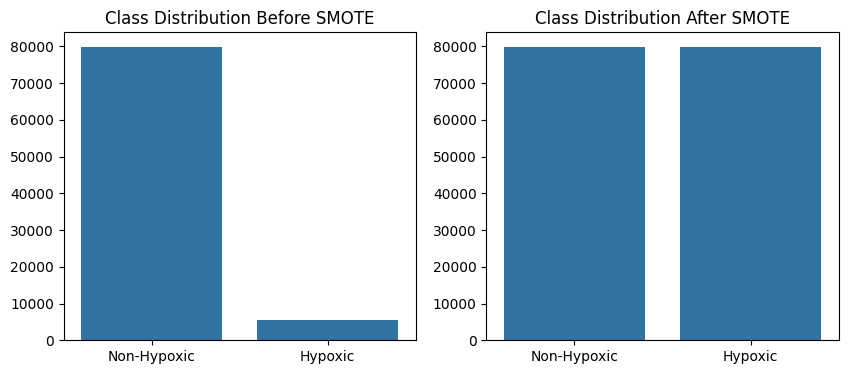

In [22]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=['Non-Hypoxic', 'Hypoxic'], y=pd.Series(y_train).value_counts().values)
plt.title("Class Distribution Before SMOTE")
plt.subplot(1, 2, 2)
sns.barplot(x=['Non-Hypoxic', 'Hypoxic'], y=[79867, 79867])
plt.title("Class Distribution After SMOTE")
plt.show()


2. Precision-Recall Curve:

This curve illustrates the trade-off between precision and recall on the holdout test set, with an Area Under the Curve (AUC) of 0.9249. The curve demonstrates strong performance, with high precision across most recall values, indicating the model's effectiveness in accurately identifying hypoxic regions while minimizing false positives.

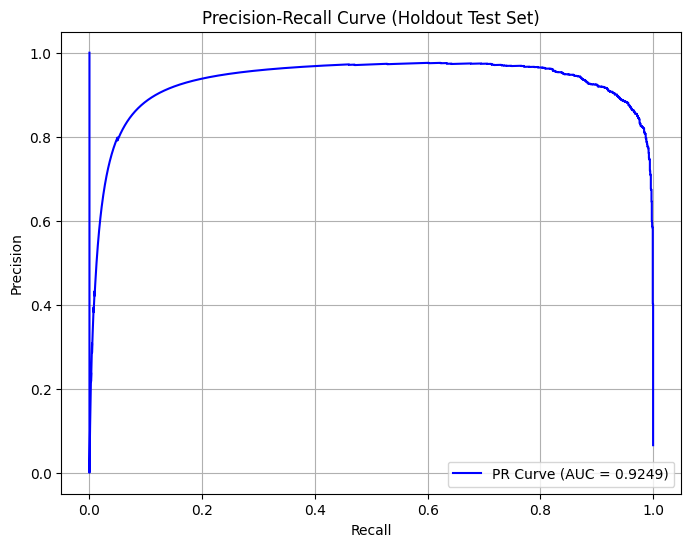

In [23]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values for holdout predictions
precision, recall, _ = precision_recall_curve(y_holdout, y_holdout_pred)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Holdout Test Set)")
plt.legend()
plt.grid(True)
plt.show()


3. ROC Curve:

The Area Under the Curve (AUC = 0.9970) indicates excellent classification performance, with the model achieving high sensitivity (True Positive Rate) while maintaining a low False Positive Rate across various thresholds.

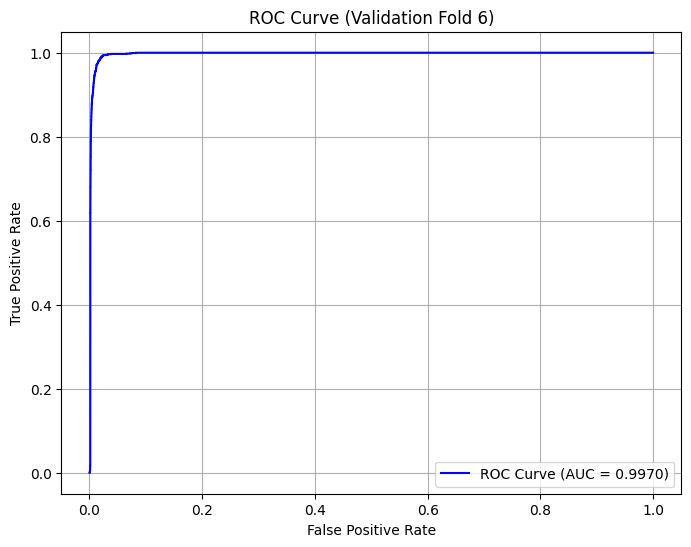

In [24]:
from sklearn.metrics import roc_curve

# Calculate FPR and TPR for ROC Curve
fpr, tpr, _ = roc_curve(y_valid, y_valid_pred)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Validation Fold {fold})")
plt.legend()
plt.grid(True)
plt.show()
